<a href="https://colab.research.google.com/github/Bouza1/breast_cancer_classification/blob/main/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proposed, improved, Machine Learning Workflow (PMLW)

The proposed, improved machine learning workflow (PMLW) is described below and aims to address the failures of CMLW and issues found in the data exploration stage.

Within the experimental results section you can see the PMLW in action and the metrics it can achieve.

## 1.   Data Preprocessing

The exploration of the dataset plays a vital role in informing the decisions for the PMLW. One of the first issues to address is missing values, to alleviate this a K-Nearest Neighbour (KNN) imputation is performed on
the whole dataset by utilizing the KNNImputer() from the Sci-Kit Learn library. The use of KNN imputation is spearheaded by its ability to capture complex patterns and relationships among the data when missing values are related to observed values such as those denoted in Figure 4 .

To mitigate the large fluctuation of numerical values seen in Appendix B, all feature variables will undergo Z-Score normalization (equation F) by using the StandardScaler() function from the Sci-Kit Learn library. All
numerical values are to be “normalized using mean and SD (Standard Deviation) of each attribute such that the resulting attributes possess zero mean and unit variance,” Singh & Singh, 2021. The use of Z-score
normalization is boosted by its inability to be affected by extreme values, of which the dataset has many. A fair comparison is drawn against min-max scaling in the evaluation section.

Recursive Feature Elimination (RFE), the RFE() function from the Sci-Kit Learn library is performed on the dataset to eliminate the most redundant features and reduce the size of the feature vector. The RFE is
conducted twice, once with a Random Forest Classifier, RandomForestClassifier(), and once with a Support Vector Machine, SVC() both from the Sci-Kit Learn library. A dataset for each of the selected features will be made with and evaluated on all 3 models (3.2) with a comparison of results shown in the Experimental results section.

To address the class imbalance an oversampling approach is put forth to utilize the Synthetic Minority Over-Sampling Technique (SMOTE), first proposed by Chawla et al., 2002, and later implemented as the Smote() function from the Sci-Kit learn library. SMOTE ensures that no data from the original dataset is lost while ensuring equilibrium of the class balance at a 50/50 split by “creating synthetic examples rather than over-sampling with duplicated real data entries”, Rahman & Davis, 2013. The justification for choosing to
oversample is that the dataset is of minimal size and under sampling would lead to a more reduced dataset in terms of size and a loss of valuable data by eliminating a third of the original dataset.


## 2.   Model Selection

The proposed models can be seen in the table below, a base result for each model will be taken as a comparison for future performances.


\begin{array}{ccc}
\text{Key}&\text{Model}&\text{Sci-Kit Learn Function}\\
LR&Logistic Regression&LogisticRegression()\\
SVM&Support Vector Machine&SVC()\\
RF&Random Forest&RandomForestClassifier()
\end{array}


The highest performing model will undergo hyper-parameter optimization, using GridSearchCV() from the Sci-Kit Learn Library.



## 3.   Validation

Validation will happen, during the stages of feature elimination using 10-fold cross validation, as a quick but computationally effective way to make the decisions needs when selecting which dataset prohibits the greatest accuracy. Holdout validation will be applied during the final model validation process. Metrics of accuracy, recall, and precision (equation D) are to be taken for all models and processes to provide a robust comparison across the PMLW. The recall score), the ratio of “correctly classified samples over all the samples
of a given class,” Bin Rafiq et al., 2020 , is the most effective metric to take within the realms of breast cancer diagnosis. Simply because the cost of misclassified a malignant tumour could be one of fatality. As such more emphasis is to be placed on the recall score compared to the precision score.

# Experimental Results

# Imports

In [1]:
# Data and Datasets
import pandas as pd
import numpy as np

# Validation methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Scale + Impute
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Hyper-parameter optimisation
from sklearn.model_selection import GridSearchCV

# Feature selection & feature engineering
from sklearn.feature_selection import RFE

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling
from imblearn.over_sampling import SMOTE

# Utils
from matplotlib.patches import Patch

# Utils

In [35]:
# This makes for quicker yet fair comparisons between different models. Eventually, holdout and cross validation will be used to gain a true reflection of the different model performances.
rand_state = 20

# Visualisation Colours And Labels
colour_list = ['steelblue', 'peachpuff']
corr_colours = sns.diverging_palette(230, 20, as_cmap=True)
formatted_labels = ['Benign','Malignant']

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load & Basic Format Dataset

In [3]:
def format_data_set():
  ''' loads the datset, drops id column and encodes target variable'''
  # df = pd.read_csv('/content/drive/MyDrive/breast-cancer.csv')
  df = pd.read_csv('data/breast-cancer.csv')
  class_map = {"B":0,"M":1}
  df['class'] = df['class'].map(class_map)
  df = df.drop(['id'], axis=1)
  return df

## Missing Values

In [13]:
def impute_missing_values_KNN():
  ''' Imputes Missing Values using K-Nearest Neighbour'''
  df = pd.read_csv('/content/drive/MyDrive/breast-cancer.csv')
  df = df.drop(['id'], axis=1)
  df.replace(0, np.nan, inplace=True)
  missing_value_rows = (df[df.isna().any(axis=1)])
  for index, row in missing_value_rows.iterrows():
      missing_columns = row.index[row.isnull()]
      if len(missing_columns) > 15:
        df.drop(index, inplace=True)
  imputer = KNNImputer(n_neighbors=3)
  class_map = {"B":0,"M":1}
  df['class'] = df['class'].map(class_map)
  return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

def drop_all_missing_values():
  '''Drops All Rows With NaNs or 0, Then Encodes The Target Variable'''
  df = pd.read_csv('/content/drive/MyDrive/breast-cancer.csv')
  df = df[(df != 0).all(axis=1)].dropna()
  class_map = {"B":0,"M":1}
  df['class'] = df['class'].map(class_map)
  return df

## Normalization

In [5]:
def scale_data_zscore(train, test):
  ''' Scales Numerical Values Using Z-Score Standardization'''
  scaler = StandardScaler()
  scaled_train = scaler.fit_transform(train)
  scaled_test = scaler.transform(test)
  return scaled_train, scaled_test

def scale_data_minmax(train, test):
  ''' Scales Numerical Values Between 0-1 '''
  scaler = MinMaxScaler()
  scaled_train = scaler.fit_transform(train)
  scaled_test = scaler.transform(test)
  return scaled_train, scaled_test


## Over-Sampling

In [7]:
def oversample(train_x, train_y):
  ''' Over samples the dataset and addresses the class imbalance'''
  smote = SMOTE(random_state=rand_state)
  X_smote, y_smote = smote.fit_resample(train_x, train_y)
  return X_smote, y_smote

## Recursive Feature Elimination (RFE)


Feature selection is performed using Recursive Feature Elimination.
Two datasets are drawn, one via the feature rankings of SVC(), support vector machine, and one by the feature rankings of the RandomForestClassifier(), random forest algorithm.

In [8]:
# Stores the feature names selected by the RFE algorithms so they can be called upon later when formatting optimal datasets.
feature_selection_dict = {"RFE - RF":[], "RFE - SVM":[]}

#### RFE - Random Forest

In [14]:
df = pd.read_csv('/content/drive/MyDrive/breast-cancer.csv')
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

In [15]:
num_features_range = range(1, len(X.columns.tolist()) + 1)

rf_accuracy_results = []
rf_best_features_list = []

# Iterate over different numbers of features while capturing accuracy, and storing features selected when accuracy is greatest.
for num_features in num_features_range:

    model_rfe = RandomForestClassifier(n_estimators=10, random_state=rand_state)

    rfe = RFE(model_rfe, n_features_to_select=num_features)
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    model_rfe.fit(X_train_rfe, y_train)

    X_test_rfe = rfe.transform(X_test)
    y_pred = model_rfe.predict(X_test_rfe)

    accuracy = accuracy_score(y_test, y_pred)
    rf_accuracy_results.append(accuracy)

    selected_features_indices = np.where(rfe.support_)[0]
    rf_best_features_list.append(selected_features_indices)

In [16]:
optimal_num_features_index = rf_accuracy_results.index(max(rf_accuracy_results))
optimal_num_features = num_features_range[optimal_num_features_index]
optimal_accuracy = rf_accuracy_results[optimal_num_features_index]
optimal_best_features = rf_best_features_list[optimal_num_features_index]

feature_selection_dict["RFE - RF"] = X.columns[optimal_best_features].tolist()

In [17]:
print(f"Optimal Number Of Features: {optimal_num_features}")
print(f"Accuracy on test set: {round(optimal_accuracy, 4)}")
print(f"Optimal Features: {X.columns[optimal_best_features].tolist()}")

Optimal Number Of Features: 14
Accuracy on test set: 0.9941
Optimal Features: ['texture_mean', 'perimter_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'area_error', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst']


#### RFE - Support Vector Machine

In [18]:
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)
X_train, X_test = scale_data_zscore(X_train, X_test)

In [19]:
svm_accuracy_results = []
svm_best_features_list = []

# Iterate over different numbers of features while capturing accuracy, and storing features selected when accuracy is greatest.
for num_features in num_features_range:

    model_rfe = SVC(kernel='linear', random_state=rand_state)

    rfe = RFE(model_rfe, n_features_to_select=num_features)
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    model_rfe.fit(X_train_rfe, y_train)

    X_test_rfe = rfe.transform(X_test)
    y_pred = model_rfe.predict(X_test_rfe)

    accuracy = accuracy_score(y_test, y_pred)
    svm_accuracy_results.append(accuracy)

    selected_features_indices = np.where(rfe.support_)[0]
    svm_best_features_list.append(selected_features_indices)

In [20]:
optimal_num_features_index = svm_accuracy_results.index(max(svm_accuracy_results))
optimal_num_features = num_features_range[optimal_num_features_index]
optimal_accuracy = svm_accuracy_results[optimal_num_features_index]
optimal_best_features = svm_best_features_list[optimal_num_features_index]

feature_selection_dict["RFE - SVM"] = X.columns[optimal_best_features].tolist()

In [21]:
print(f"Optimal Number Of Features: {optimal_num_features}")
print(f"Recall on test set: {round(optimal_accuracy, 4)}")
print(f"Optimal Features: {X.columns[optimal_best_features].tolist()}")

Optimal Number Of Features: 7
Recall on test set: 0.9882
Optimal Features: ['compactness_mean', 'concave_points_mean', 'area_error', 'texture_worst', 'area_worst', 'concave_points_worst', 'symmetry_worst']


#### RFE - Results Comparison

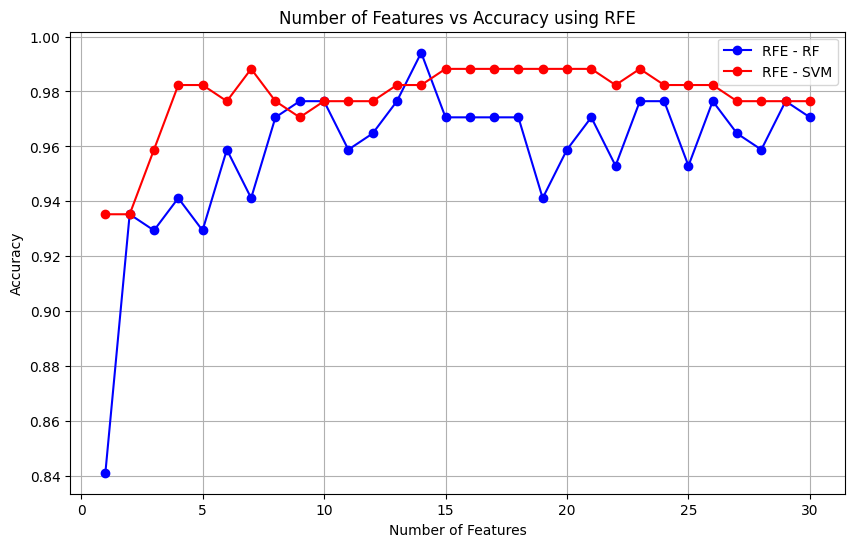

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(num_features_range, rf_accuracy_results, marker='o', linestyle='-', color='b', label='RFE - RF')
plt.plot(num_features_range, svm_accuracy_results, marker='o', linestyle='-', color='r', label='RFE - SVM')
plt.title('Number of Features vs Accuracy using RFE')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Comments:

The chart above shows the accuracy of SVM to be optimal when 7 features were used  while the RandomForest rquired 14 features. 10-fold Validation will be carried out against bas emodels and both datasets to see which dataset and models are the best performing.

### 10-Fold Validation of chosen datasets
Please Note: Results may not be 100% correct to the concluding remarks below because the random state is not set.



In [23]:
def return_features_selected_data_sets(input_df, feature_group):
  ''' Returns a dataset comprising of the selected feature groups'''
  new_df = input_df[feature_selection_dict[feature_group]]
  return new_df

def add_feautures_score(results_dict, model, dataset, accuracy, std_dev):
  ''' Adds score to result dict'''
  results_dict[model][dataset]["accuracy"] = accuracy
  results_dict[model][dataset]["std"] = std_dev

In [30]:
# 10 Fold Validation of Feature Datasets on Base Models
feature_score_valid_dict = {"LR":{"name":"Logistic Regression After Feature Selection","RFE - SVM":{"accuracy":0, "std":0}, "RFE - RF":{"accuracy":0, "std":0}},
                            "RF":{"name":"Random Forest After Feature Selection", "RFE - SVM":{"accuracy":0, "std":0}, "RFE - RF":{"accuracy":0, "std":0}},
                            "SVM":{"name":"Support Vector Machine After Feature Selection", "RFE - SVM":{"accuracy":0, "std":0}, "RFE - RF":{"accuracy":0, "std":0}}
                            }

In [31]:
chosen_models = {"LR":{"model":LogisticRegression(), "scale":True, "name":"Logistic Regression"}, "RF":{"model":RandomForestClassifier(), "scale":False, "name":"Random Forest"}, "SVM":{"model":SVC(), "scale":True, "name":"Support Vector Machine"}}
datasets = ['RFE - SVM', 'RFE - RF']

In [32]:
for dataset in datasets:
  df = impute_missing_values_KNN()
  X = df.iloc[:, :len(df.columns) - 1]
  y = df.iloc[:, len(df.columns) - 1]
  X = return_features_selected_data_sets(X, dataset)
  X_smote, y_smote = oversample(X,y)
  for key, model in chosen_models.items():
    if model['scale']:
        new_model = make_pipeline(StandardScaler(), model['model'])
    else:
        new_model = model['model']

    kf = KFold(n_splits=10, shuffle=True)

    cross_val_scores = cross_val_score(new_model, X_smote, y_smote, cv=kf)
    add_feautures_score(feature_score_valid_dict, key, dataset, np.mean(cross_val_scores), np.std(cross_val_scores))

In [33]:
for key, results in feature_score_valid_dict.items():
  print('\n')
  print(results['name'])
  print(f"RFE-RF: {results['RFE - RF']['accuracy']}")
  print(f"RFE - SVM: {results['RFE - SVM']['accuracy']}")



Logistic Regression After Feature Selection
RFE-RF: 0.9788732394366197
RFE - SVM: 0.9663145539906104


Random Forest After Feature Selection
RFE-RF: 0.9775430359937403
RFE - SVM: 0.974706572769953


Support Vector Machine After Feature Selection
RFE-RF: 0.9761345852895147
RFE - SVM: 0.9719287949921753


#### Comments:

The results indicate that the RFE-RF Dataset was the optimal dataset, in terms of performance, for all base models. As such, moving forward the focus will be on RFE-RF as the main dataset.

# Model Selection

### Util Functions

In [34]:
def add_result(results_dict, model, y_test, y_pred, multi=False):
  ''' Adds a result to a results dictionary'''
  if multi:
      results_dict[model]['accuracy'].append(accuracy_score(y_test, y_pred))
      results_dict[model]['precision'].append(precision_score(y_test, y_pred, average='macro'))
      results_dict[model]['recall'].append(recall_score(y_test, y_pred, average='macro'))
      results_dict[model]['confusion_matrix'].append(confusion_matrix(y_test, y_pred))
  else:
    results_dict[model]['accuracy'] = accuracy_score(y_test, y_pred)
    results_dict[model]['precision'] = precision_score(y_test, y_pred, average='macro', zero_division=0)
    results_dict[model]['recall'] = recall_score(y_test, y_pred, average='macro', zero_division=0)
    results_dict[model]['confusion_matrix'] = confusion_matrix(y_test, y_pred)

def create_results_frame(results_dict, multi=False):
  ''' Creates a dataframe from a results dictionary. Can Handle Holdout Results too by setting multi=True'''
  if multi:
    result_df = pd.DataFrame(columns=['Model','Accuracy Mean','Accuracy STD', 'Precision Mean', 'Precision STD','Recall Mean', 'Recall STD'])
    for result in results_dict:
      result_df.loc[len(result_df)] = {'Model':results_dict[result]['name'], 'Accuracy Mean':results_dict[result]['accuracy'][0], 'Accuracy STD':round(results_dict[result]['accuracy'][1], 2), 'Precision Mean':results_dict[result]['precision'][0], 'Precision STD':round(results_dict[result]['precision'][1],2),'Recall Mean':results_dict[result]['recall'][0], 'Recall STD':round(results_dict[result]['recall'][1],2)}
    result_df = result_df.sort_values(by=['Accuracy Mean'], ascending=False)
  else:
    result_df = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall'])
    for result in results_dict:
      result_df.loc[len(result_df)] = {'Model':results_dict[result]['name'], 'Accuracy':results_dict[result]['accuracy'], 'Precision':results_dict[result]['precision'], 'Recall':results_dict[result]['recall']}
    result_df = result_df.sort_values(by=['Accuracy'], ascending=False)
  return result_df

def show_results_frame(result_df):
  ''' Styles and shows a dataframe'''
  formatted_df = result_df.style.hide(axis="index")
  return formatted_df

def show_results_chart(result_df, title):
  ''' Styles and shows a dataframe results as a bar chart'''
  chart_results = result_df.set_index('Model')
  ax = chart_results.plot(kind='bar', rot=45, figsize=(15, 7), colormap='Paired')
  for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 4)), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='bottom' if p.get_height() >= 0 else 'top', rotation='vertical', xytext=(0, -40) if p.get_height() >= 0 else (0, -10), textcoords='offset points')
  plt.xlabel('Model')
  plt.ylabel('Score')
  plt.title(title)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.tight_layout()
  plt.show()

def print_model_comparison(results_df, model_a, model_b):
  ''' Prints Results Of a Model Comparison'''
  a_accuracy = results_df.loc[results_df['Model'] == model_a, 'Accuracy'].iloc[0]
  a_precision = results_df.loc[results_df['Model'] == model_a, 'Precision'].iloc[0]
  a_recall = results_df.loc[results_df['Model'] == model_a, 'Recall'].iloc[0]
  b_accuracy = results_df.loc[results_df['Model'] == model_b, 'Accuracy'].iloc[0]
  b_precision = results_df.loc[results_df['Model'] == model_b, 'Precision'].iloc[0]
  b_recall = results_df.loc[results_df['Model'] == model_b, 'Recall'].iloc[0]
  print(f"Accuracy Difference: {round((a_accuracy - b_accuracy)*100, 2)}%")
  print(f"Precision Difference: {round((a_precision - b_precision)*100, 2)}%")
  print(f"Recall Difference: {round((a_recall - b_recall)*100, 2)}%")

def concat_frames(df_array, drop_std=True):
  ''' Concats an Array of Dataframes'''
  comparison_frame = pd.concat(df_array, ignore_index=True)
  comparison_frame = comparison_frame.sort_values(by='Recall')
  if drop_std:
    to_drop = ['Accuracy STD', 'Precision STD', 'Recall STD']
    comparison_frame = comparison_frame.drop(columns=to_drop)
  return comparison_frame

def plot_multi_confusion_matrix(results):
  ''' Plots Multiple Confusion Matrixs '''
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
  i = 0
  for model, result in results.items():
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], xticklabels=formatted_labels,  yticklabels=formatted_labels)
    axes[i].set_title(f'Confusion Matrix: {result["name"]}')
    i += 1
  plt.tight_layout()
  plt.show()

## Base Models

In [36]:
# Base Models
base_models = {"LR":{'model':LogisticRegression(max_iter=6000, random_state=rand_state), "scale":True}, "RF":{"model":RandomForestClassifier(), "scale":False}, "SVM":{"model": SVC(random_state=rand_state), "scale":True}}

In [37]:
# Base Model Results Dictionary
base_models_result_dict = {"LR":{"name":"LR (Base)"}, "RF":{"name":"RF (Base)"}, "SVM":{"name":"SVM (Base)"}}

In [38]:
# Split Data
df = drop_all_missing_values()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

In [39]:
# Single Run of Each Base Model
for key, obj in base_models.items():
  model = obj['model']
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(base_models_result_dict, key, y_test, y_pred)
# Create Results Frame
base_models_frame = create_results_frame(base_models_result_dict)

In [40]:
# Show Results
print("Base Model Results On Original Dataset No Preprocessing")
show_results_frame(base_models_frame)

Base Model Results On Original Dataset No Preprocessing


Model,Accuracy,Precision,Recall
RF (Base),0.975000,0.976648,0.969236
LR (Base),0.637500,0.318750,0.500000
SVM (Base),0.637500,0.318750,0.500000


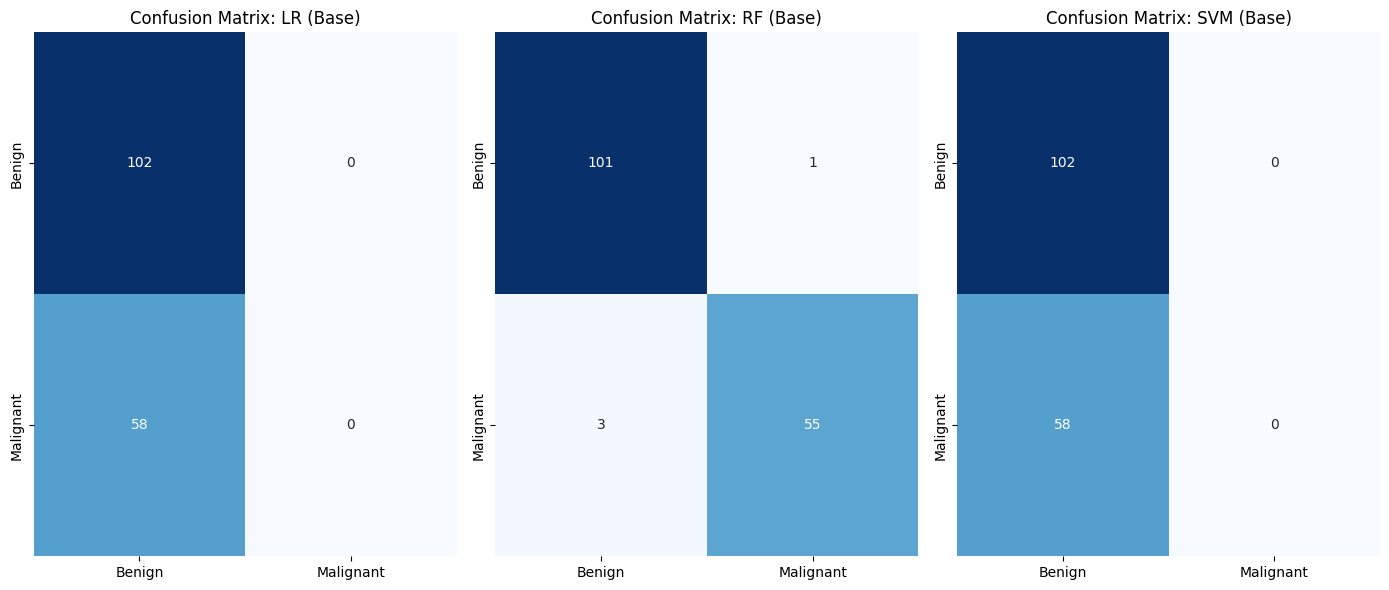

In [41]:
# Plot Confusion Matrics For Base Models
plot_multi_confusion_matrix(base_models_result_dict)

### Comments
As expected, the results of LR and SVM indicate the models are facing the same issues as the CMLW where it is misclassifying the minority class (Malignant). This is corroborated in the confusion matrix above, where LR and SVM have 58 False Positives each and 0 True Negatives.

## Base Models - Imputation

### KNN Imputation

In [42]:
# KNN Imputation Results Dictionary
knn_imp_results_dict = {"LR":{"name":"LR (KNN Imputation)"}, "RF":{"name":"RF (KNN Imputation)"}, "SVM":{"name":"SVM (KNN Imputation)"}}

In [43]:
# Split Data
df = impute_missing_values_KNN()
X = df.iloc[:, :len(df.columns) - 1]
y = df.iloc[:, len(df.columns) - 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

In [44]:
# Single Run of Base Models
for key, obj in base_models.items():
  model = obj['model']
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(knn_imp_results_dict, key, y_test, y_pred)
# Create Results Frame
knn_imp_frame = create_results_frame(knn_imp_results_dict)

In [45]:
# Show Results
print("Base Model Results On Original Dataset with Z-Score Normalization")
show_results_frame(knn_imp_frame)

Base Model Results On Original Dataset with Z-Score Normalization


Model,Accuracy,Precision,Recall
RF (KNN Imputation),0.964706,0.959459,0.970588
LR (KNN Imputation),0.947059,0.945877,0.943627
SVM (KNN Imputation),0.929412,0.934140,0.919118


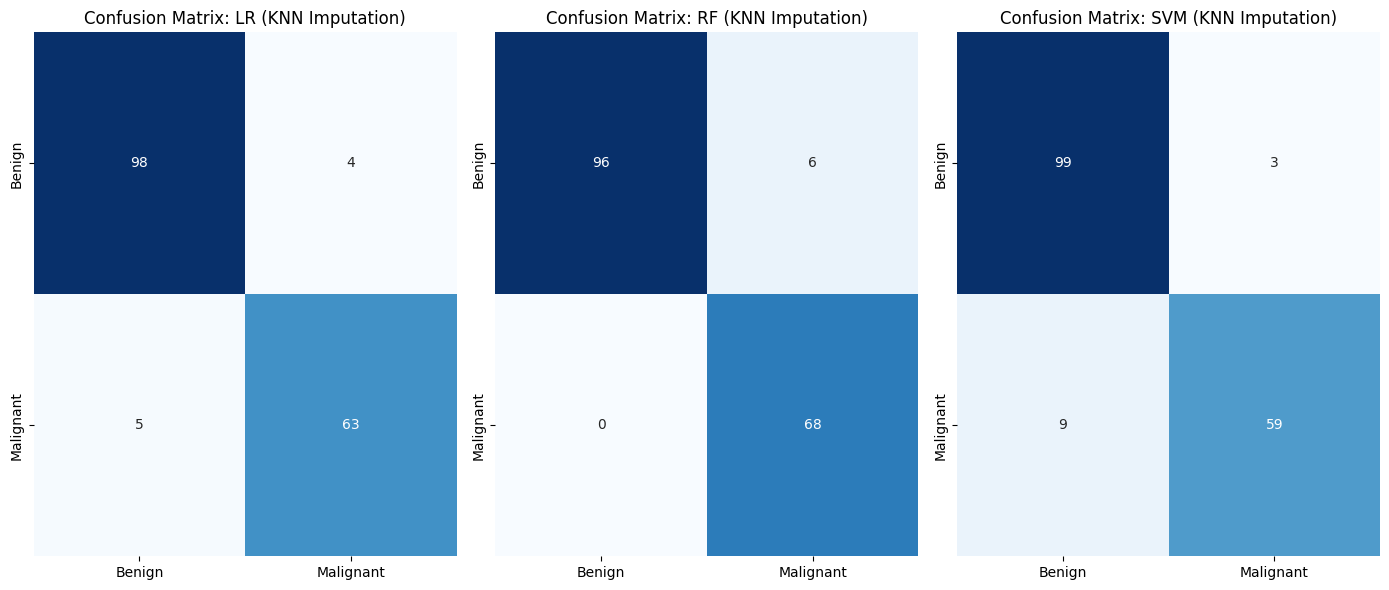

In [ ]:
# Plot Confusion Matrics For Base Models
plot_multi_confusion_matrix(knn_imp_results_dict)

### Comments

After imputing the values using KNN imputation both the LR and SVM models drastically increased in terms of accuracy, precision, and recall. The RF model has fallen in terms of accuracy and precision, but the recall score, the more import metric has increased. Results indicate the use KNN-Imputation to more effective than the drop_na() (section 4.1) approach, in line with those of Jadhav et al., 2019 who found “KNN imputation method outperforms the other methods”.

## Data Normalization

Normalization of the dataset is performed using both Z-Score and Min-Max with a comparison drawn between the two to show which is more effective.

### Z-Score Normalization

In [46]:
# Z-Score Normalization Results Dictionary
z_score_results_dict = {"LR":{"name":"LR (Z-Score)"}, "RF":{"name":"RF (Z-Score)"}, "SVM":{"name":"SVM (Z-Score)"}}

In [47]:
# Split Data
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)
X_train, X_test = scale_data_zscore(X_train, X_test)

In [48]:
# Single Run after Z-Score Normalization
for key, obj in base_models.items():
  model = obj['model']
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(z_score_results_dict, key, y_test, y_pred)
# Create Results Frame
z_score_frame = create_results_frame(z_score_results_dict)

In [49]:
# Show Results
print("Base Model Results On Original Dataset with Z-Score Normalization")
show_results_frame(z_score_frame)

Base Model Results On Original Dataset with Z-Score Normalization


Model,Accuracy,Precision,Recall
LR (Z-Score),0.994118,0.992754,0.995098
SVM (Z-Score),0.976471,0.975490,0.975490
RF (Z-Score),0.970588,0.965753,0.975490


### Min - Max Normalization

In [50]:
# Min-Max Results Dictionary
minmax_results_dict = {"LR":{"name":"LR (Min-Max)"}, "RF":{"name":"RF (Min-Max)"}, "SVM":{"name":"SVM (Min-Max)"}}

In [51]:
# Split Data
df = drop_all_missing_values()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)
X_train, X_test = scale_data_minmax(X_train, X_test)

In [52]:
# Single Run  After Min-Max Normalization
for key, obj in base_models.items():
  model = obj['model']
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(minmax_results_dict, key, y_test, y_pred)
minmax_frame = create_results_frame(minmax_results_dict)

In [53]:
# Show Results
print("Base Model Results On Original Dataset with Z-Score Normalization")
show_results_frame(minmax_frame)

Base Model Results On Original Dataset with Z-Score Normalization


Model,Accuracy,Precision,Recall
SVM (Min-Max),0.975000,0.976648,0.969236
RF (Min-Max),0.968750,0.971861,0.960615
LR (Min-Max),0.956250,0.962529,0.943374


### Comparison of Z-Score vs Min-Max Normalization

In [54]:
normalization_comparison = concat_frames([z_score_frame, minmax_frame], drop_std=False)
show_results_frame(normalization_comparison)

Model,Accuracy,Precision,Recall
LR (Min-Max),0.956250,0.962529,0.943374
RF (Min-Max),0.968750,0.971861,0.960615
SVM (Min-Max),0.975000,0.976648,0.969236
SVM (Z-Score),0.976471,0.975490,0.975490
RF (Z-Score),0.970588,0.965753,0.975490
LR (Z-Score),0.994118,0.992754,0.995098


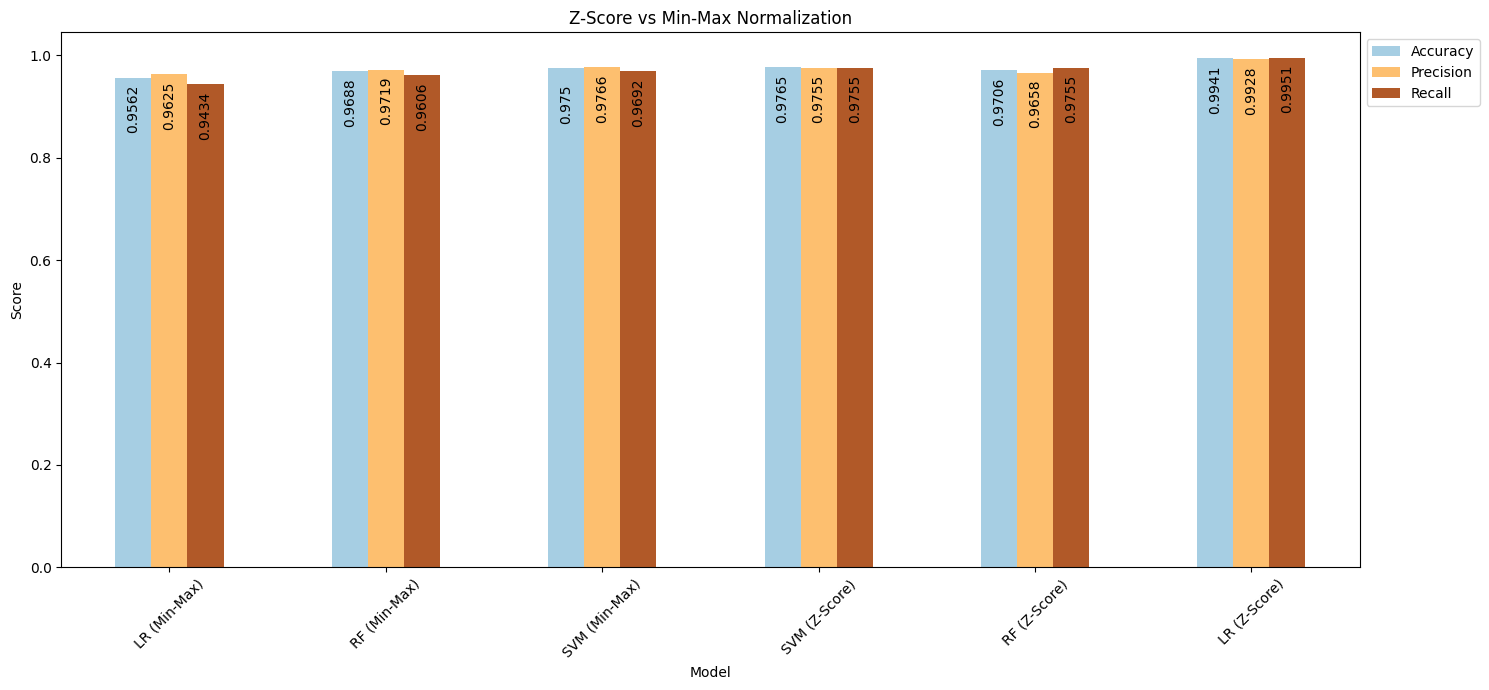

In [55]:
show_results_chart(normalization_comparison, "Z-Score vs Min-Max Normalization")

### Comments
After Z-score normalization, the three metrics for LR and SVM have increased, while in general there is a positive increase when using Z-Score over Min-Max normalization. These results are in line with, Singh & Singh, 2021 who conclude “z-score is more appropriate in comparison to min-max and median techniques
for data normalization”.

## Base Models After Feature Selection

All models are tested against the RFE-RF & RFE-SVM datasets

In [56]:
def return_features_selected_data_sets(input_df, feature_group):
  ''' Returns a dataset comprising of the selected feature groups'''
  new_df = input_df[feature_selection_dict[feature_group]]
  return new_df

In [57]:
base_models = {"LR":{'model':LogisticRegression(max_iter=6000, random_state=rand_state), "scale":True}, "RF":{"model":RandomForestClassifier(), "scale":False}, "SVM":{"model": SVC(random_state=rand_state), "scale":True}}

### RFE-SVM Dataset

In [58]:
# Split Data Taking Only the Features Selected By SVM-RFE
df = impute_missing_values_KNN()
X = df.iloc[:, :len(df.columns) - 1]
X = return_features_selected_data_sets(X, 'RFE - SVM')
y = df.iloc[:, len(df.columns) - 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

In [59]:
print("Dataset Info:")
X.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   compactness_mean      566 non-null    float64
 1   concave_points_mean   566 non-null    float64
 2   area_error            566 non-null    float64
 3   texture_worst         566 non-null    float64
 4   area_worst            566 non-null    float64
 5   concave_points_worst  566 non-null    float64
 6   symmetry_worst        566 non-null    float64
dtypes: float64(7)
memory usage: 31.1 KB


In [60]:
# Base Models - RFE-SVM Results Dictionary
base_RFESVMF_results_dict = {"LR":{"name":"LR (RFE - SVM)"}, "RF":{"name":"RF (RFE - SVM)"}, "SVM":{"name":"SVM (RFE - SVM)"}}

In [61]:
# Single Run On RFE-SVM Dataset
for key, model in chosen_models.items():
  if model['scale']:
    X_train, X_test = scale_data_zscore(X_train, X_test)
  model = model['model']
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(base_RFESVMF_results_dict, key, y_test, y_pred)
# Create Results Frame
base_RFESVM_frame = create_results_frame(base_RFESVMF_results_dict)

In [62]:
# Show Results
print("Base Model Results On RFE - SVM Dataset")
show_results_frame(base_RFESVM_frame)

Base Model Results On RFE - SVM Dataset


Model,Accuracy,Precision,Recall
LR (RFE - SVM),0.988235,0.987745,0.987745
SVM (RFE - SVM),0.982353,0.982829,0.980392
RF (RFE - SVM),0.958824,0.953749,0.963235


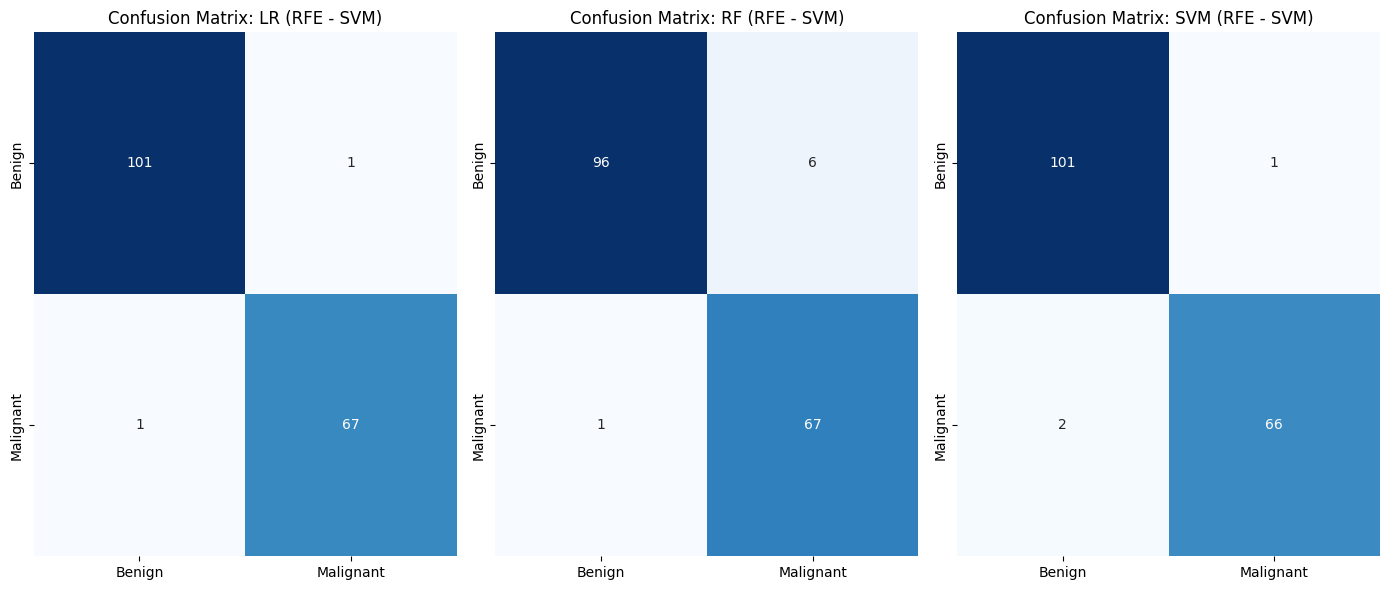

In [69]:
plot_multi_confusion_matrix(base_RFESVMF_results_dict)

### RFE-RF Dataset

In [63]:
# Base Model - RFE-RF Results Dictionary
base_RFERF_results_dict = {"LR":{"name":"LR (RFE - RF)"}, "RF":{"name":"RF (RFE - RF)"}, "SVM":{"name":"SVM (RFE - RF)"}}

In [64]:
# Split Data
df = impute_missing_values_KNN()
X = df.iloc[:, :len(df.columns) - 1]
y = df.iloc[:, len(df.columns) - 1]
X = return_features_selected_data_sets(X, 'RFE - RF')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

In [70]:
print("Dataset Info:")
X.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   texture_mean          566 non-null    float64
 1   perimter_mean         566 non-null    float64
 2   compactness_mean      566 non-null    float64
 3   concavity_mean        566 non-null    float64
 4   concave_points_mean   566 non-null    float64
 5   area_error            566 non-null    float64
 6   radius_worst          566 non-null    float64
 7   texture_worst         566 non-null    float64
 8   perimeter_worst       566 non-null    float64
 9   area_worst            566 non-null    float64
 10  smoothness_worst      566 non-null    float64
 11  concavity_worst       566 non-null    float64
 12  concave_points_worst  566 non-null    float64
 13  symmetry_worst        566 non-null    float64
dtypes: float64(14)
memory usage: 62.0 KB


In [71]:
# Single Run on RFE-RF Dataset
for key, model in chosen_models.items():
  if model['scale']:
    X_train, X_test = scale_data_zscore(X_train, X_test)
  model = model['model']
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(base_RFERF_results_dict, key, y_test, y_pred)
# Create Results Frame
base_RFERF_frame = create_results_frame(base_RFERF_results_dict)

In [72]:
# Show Results
print("Base Model Results On RFE - RF Dataset")
show_results_frame(base_RFERF_frame)

Base Model Results On RFE - RF Dataset


Model,Accuracy,Precision,Recall
LR (RFE - RF),1.000000,1.000000,1.000000
SVM (RFE - RF),0.982353,0.982829,0.980392
RF (RFE - RF),0.976471,0.973571,0.977941


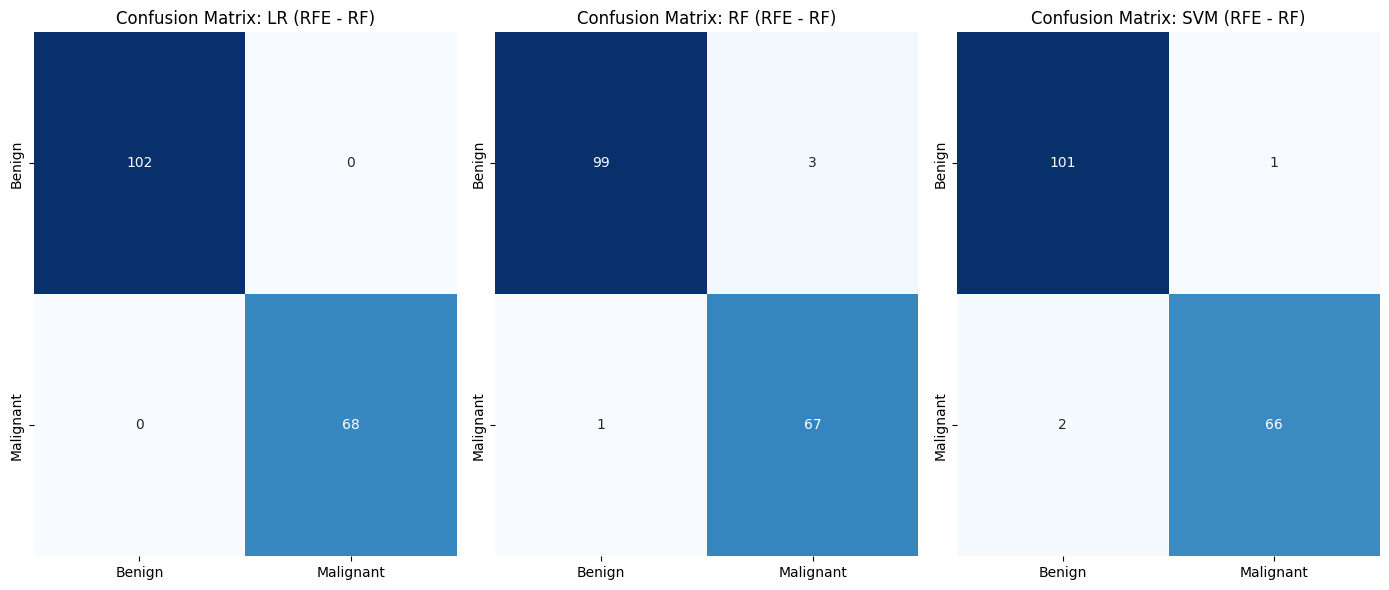

In [73]:
plot_multi_confusion_matrix(base_RFERF_results_dict)

### Comments

All models performed with greater accuracy, precision and recall when using the RFE-RF dataset, This leads to the selection of the RFE-RF as the core dataset to be implemented in the PMLW.


## Base Models After Class Balance Addressed

In [74]:
def oversample(train_x, train_y):
  ''' Oversamples X_train and y_train '''
  smote = SMOTE(random_state=rand_state)
  X_smote, y_smote = smote.fit_resample(X_train, y_train)
  return X_smote, y_smote

In [75]:
# SMOTE Results Dict
smote_results_dict = {"LR":{"name":"LR (SMOTE)"}, "RF":{"name":"RF (SMOTE)"}, "SVM":{"name":"SVM (SMOTE)"}}

In [76]:
# Split Data
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)
# Apply Smote
X_train, y_train = oversample(X_train, y_train)

In [77]:
# Single Run After SMOTE applied
for key, model in chosen_models.items():
  if model['scale']:
    X_train, X_test = scale_data_zscore(X_train, X_test)
  model = model['model']
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(smote_results_dict, key, y_test, y_pred)
# Create Results Frame
smote_results_frame = create_results_frame(smote_results_dict)

In [78]:
# Show Results
print("Base Model Results On RFE - RF Dataset")
show_results_frame(smote_results_frame)

Base Model Results On RFE - RF Dataset


Model,Accuracy,Precision,Recall
LR (SMOTE),0.988235,0.985714,0.990196
SVM (SMOTE),0.988235,0.987745,0.987745
RF (SMOTE),0.964706,0.959459,0.970588


### Comments

Although the LR model has dropped in terms of accuracy, precision, and recall when compared to those in table 6 , RF & SVM both saw increases in the recall score. Suggesting oversampling is a good method to address the class imbalance and boost the recall score.

## 10-Fold Validation of PMLW and Base Models

In [79]:
# Ten Fold Validation Results Dict
ten_fold_results_dict = {"LR":{"name":"LR (10-Fold)"}, "RF":{"name":"RF (10-Fold)"}, "SVM":{"name":"SVM (10-Fold)"}}

In [80]:
# Preprocess Data
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')

In [81]:
# 10-Fold Validation of all Base Models
for key, model in base_models.items():
  if model['scale']:
    new_model = make_pipeline(StandardScaler(), model['model'])
  else:
    new_model = model['model']
  kf = KFold(n_splits=10, shuffle=True)
  cross_val_scores = cross_validate(new_model, X, y, cv=kf, scoring=['precision', 'recall', 'accuracy'])
  ten_fold_results_dict[key]['accuracy'] = cross_val_scores['test_accuracy'].mean()
  ten_fold_results_dict[key]['precision'] = cross_val_scores['test_precision'].mean()
  ten_fold_results_dict[key]['recall'] = cross_val_scores['test_recall'].mean()
# Create Results Frame
ten_fold_results_frame = create_results_frame(ten_fold_results_dict)

In [83]:
# Show Results Frame
print("Base Models on Full PMLW")
show_results_frame(ten_fold_results_frame)

Base Models on Full PMLW


Model,Accuracy,Precision,Recall
LR (10-Fold),0.980608,0.978671,0.968609
SVM (10-Fold),0.975219,0.976104,0.958493
RF (10-Fold),0.970019,0.970067,0.947184


### Comments
Although the three metrics for LR have dropped compared to some of the base mode comparisons, it is worth noting the base models are all trained on a predetermined random state with no validation.

# Final Model

Logisitic Regression (LR) is the best performing terms of Recall (the more important metric to breast cancer). Therefore, we will move forward to hyper paramater optimization of the LR Model.

In [84]:
model = LogisticRegression()

## LR Hyper Parameter Optimisation

Although argubaly there are not many critical hyper parameters within the logisitc regression that most important ones such as C, solver, and penalty have been fine ottimpized.

In [85]:
# Hyper Parameter Results Dicts
hyper_params_dict = {"LR":{"name":"Logistic Regression"}}
param_dict = {
      "LR":[{
    'penalty': ['l2', 'none'],
    'C': [ 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'max_iter': [50, 100, 200, 400]
    },{
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['liblinear'],
    'max_iter': [50, 100, 200, 400]
    }]}

In [86]:
# Full Data Preprocessing of PMLW
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)
X_train, y_train = oversample(X_train, y_train)
X_train, X_test = scale_data_zscore(X_train, X_test)

In [87]:
grid_search = GridSearchCV(estimator=model, param_grid=param_dict['LR'], cv=10, scoring='accuracy', n_jobs=2, error_score='raise')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

# Stores Params in a dictionary so can be called upon later
hyper_params_dict['LR']['best_params'] = best_params

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Stores Hyper Params Results On Test Set
hyper_params_dict['LR']['accuracy'] = accuracy_score(y_test, y_pred)
hyper_params_dict['LR']['precision'] = precision_score(y_test, y_pred, average='macro')
hyper_params_dict['LR']['recall'] = recall_score(y_test, y_pred, average='macro')
hyper_params_dict['LR']['y_test'] = y_test
hyper_params_dict['LR']['y_pred'] = y_pred

In [92]:
# Print Hyper Parameters Selected And Results On Test Set
print(f"Best Params: {hyper_params_dict['LR']['best_params']}")
print("Model Performance:")
print(f"Accuracy: {hyper_params_dict['LR']['accuracy']}")
print(f"Precision: {hyper_params_dict['LR']['precision']}")
print(f"Recall: {hyper_params_dict['LR']['recall']}")

Best Params: {'C': 10, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Model Performance:
Accuracy: 0.9882352941176471
Precision: 0.9857142857142858
Recall: 0.9901960784313726


# Full PMLW Holdout Validation & Comparison

Please Note: The following results within this section might not accurately reflect the those of the concluding remarks, however they should be of a very similiar nature considering the validation is done over a one thousand run holdout.

## Utils

In [93]:
num_runs=1000

In [94]:
def test_train_split_oversample(X, y):
  ''' Splits Test Train Data While Applying SMOTE() to X_train and Y_train'''
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
  smote = SMOTE(random_state=None)
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
  X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
  X_test = pd.DataFrame(X_test, columns=X_train.columns)
  return X_train_resampled, X_test, y_train_resampled, y_test

def print_holdout_results(holdout_validation_dict):
  ''' Prints Holdout Validation Results'''
  print(f"Accuracy: {round((np.array(holdout_validation_dict['LR']['accuracy']).mean()),6)}, (+/- {round((np.array(holdout_validation_dict['LR']['accuracy']).std()*2),3)})")
  print(f"Percision: {round((np.array(holdout_validation_dict['LR']['precision']).mean()),6)}, (+/- {round((np.array(holdout_validation_dict['LR']['precision']).std()*2),3)})")
  print(f"Recall: {round((np.array(holdout_validation_dict['LR']['recall']).mean()),6)}, (+/- {round((np.array(holdout_validation_dict['LR']['recall']).std()*2),3)})")

## Full PMLW

In [95]:
# Model
model = LogisticRegression()
model.set_params(**hyper_params_dict['LR']['best_params'])

LogisticRegression(C=10, max_iter=50, solver='newton-cg')

In [96]:
# Data Split
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')

In [97]:
# Results Dict
holdout_validation_dict_RFERF = {"LR":{"name":"LR (PMLW)", "accuracy":[], "precision":[], "recall":[], "confusion_matrix":[]}}
# Holdout Run
for i in range(0, num_runs):
  X_train, X_test, y_train, y_test = test_train_split_oversample(X,y)
  X_train, X_test = scale_data_zscore(X_train, X_test)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(holdout_validation_dict_RFERF, 'LR', y_test, y_pred, multi=True)

In [98]:
# Final Results
print(f"After {num_runs}:")
print_holdout_results(holdout_validation_dict_RFERF)

After 1000:
Accuracy: 0.973135, (+/- 0.022)
Percision: 0.971688, (+/- 0.024)
Recall: 0.970968, (+/- 0.024)


## Utilities

In [ ]:
num_runs=1000

In [ ]:
def test_train_split_oversample(X, y):
  ''' Splits Test Train Data While Applying SMOTE() to X_train and Y_train'''
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
  smote = SMOTE(random_state=None)
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
  X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
  X_test = pd.DataFrame(X_test, columns=X_train.columns)
  return X_train_resampled, X_test, y_train_resampled, y_test

def print_holdout_results(holdout_validation_dict):
  ''' Prints Holdout Validation Results'''
  print(f"Accuracy: {round((np.array(holdout_validation_dict['LR']['accuracy']).mean()),6)}, (+/- {round((np.array(holdout_validation_dict['LR']['accuracy']).std()*2),3)})")
  print(f"Percision: {round((np.array(holdout_validation_dict['LR']['precision']).mean()),6)}, (+/- {round((np.array(holdout_validation_dict['LR']['precision']).std()*2),3)})")
  print(f"Recall: {round((np.array(holdout_validation_dict['LR']['recall']).mean()),6)}, (+/- {round((np.array(holdout_validation_dict['LR']['recall']).std()*2),3)})")

## Full PMLW

In [ ]:
# Model
model = LogisticRegression()
model.set_params(**hyper_params_dict['LR']['best_params'])

LogisticRegression(C=10, max_iter=50, solver='newton-cg')

In [ ]:
# Data Split
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')

In [ ]:
# Results Dict
holdout_validation_dict_RFERF = {"LR":{"name":"LR (PMLW)", "accuracy":[], "precision":[], "recall":[], "confusion_matrix":[]}}
# Holdout Run
for i in range(0, num_runs):
  X_train, X_test, y_train, y_test = test_train_split_oversample(X,y)
  X_train, X_test = scale_data_zscore(X_train, X_test)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(holdout_validation_dict_RFERF, 'LR', y_test, y_pred, multi=True)

In [ ]:
# Final Results
print(f"After {num_runs}:")
print_holdout_results(holdout_validation_dict_RFERF)

After 1000:
Accuracy: 0.973124, (+/- 0.022)
Percision: 0.971489, (+/- 0.025)
Recall: 0.971094, (+/- 0.025)


## PMLW on RFE-SVM Dataset

In [ ]:
# Model
model = LogisticRegression()
model.set_params(**hyper_params_dict['LR']['best_params'])

LogisticRegression(C=10, max_iter=50, solver='newton-cg')

In [ ]:
# Data Split
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - SVM')

In [ ]:
# Results Dict
holdout_validation_dict_RFESVM = {"LR":{"name":"LR (RFE-SVM)", "accuracy":[], "precision":[], "recall":[], "confusion_matrix":[]}}
#Holdout Run
for i in range(0, num_runs):
  X_train, X_test, y_train, y_test = test_train_split_oversample(X,y)
  X_train, X_test = scale_data_zscore(X_train, X_test)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(holdout_validation_dict_RFESVM, 'LR', y_test, y_pred, multi=True)

In [ ]:
# Final Results
print(f"After {num_runs}:")
print_holdout_results(holdout_validation_dict_RFESVM)

After 1000:
Accuracy: 0.968276, (+/- 0.023)
Percision: 0.966173, (+/- 0.026)
Recall: 0.966212, (+/- 0.024)


## PMLW on Full Dataset

In [ ]:
# Model
model = LogisticRegression()
model.set_params(**hyper_params_dict['LR']['best_params'])

LogisticRegression(C=10, max_iter=50, solver='newton-cg')

In [ ]:
# Data Split
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]

In [ ]:
# Results Dict
holdout_validation_dict_fulldf = {"LR":{"name":"LR (Full Dataset)", "accuracy":[], "precision":[], "recall":[], "confusion_matrix":[]}}
#Holdout Run
for i in range(0, num_runs):
  X_train, X_test, y_train, y_test = test_train_split_oversample(X,y)
  X_train, X_test = scale_data_zscore(X_train, X_test)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(holdout_validation_dict_fulldf, 'LR', y_test, y_pred, multi=True)

In [ ]:
# Final Results
print(f"After {num_runs}:")
print_holdout_results(holdout_validation_dict_fulldf)

After 1000:
Accuracy: 0.965759, (+/- 0.026)
Percision: 0.964094, (+/- 0.029)
Recall: 0.962721, (+/- 0.029)


## PMLW No Hyper Parameters

In [ ]:
# Model
model = LogisticRegression()

In [ ]:
# Data Split
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')

In [ ]:
# Results Dict
holdout_validation_dict_nohyper = {"LR":{"name":"LR (No Hyper Params)", "accuracy":[], "precision":[], "recall":[], "confusion_matrix":[]}}
#Holdout Run
for i in range(0, num_runs):
  X_train, X_test, y_train, y_test = test_train_split_oversample(X,y)
  X_train, X_test = scale_data_zscore(X_train, X_test)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(holdout_validation_dict_nohyper, 'LR', y_test, y_pred, multi=True)

In [ ]:
# Final Results
print(f"After {num_runs}:")
print_holdout_results(holdout_validation_dict_nohyper)

After 1000:
Accuracy: 0.9783, (+/- 0.021)
Percision: 0.977423, (+/- 0.023)
Recall: 0.976115, (+/- 0.024)


## PMLW No SMOTE



In [ ]:
# Model
model = LogisticRegression()
model.set_params(**hyper_params_dict['LR']['best_params'])

LogisticRegression(C=10, max_iter=50, solver='newton-cg')

In [ ]:
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')

In [ ]:
holdout_validation_dict_nosmote = {"LR":{"name":"LR (No SMOTE)", "accuracy":[], "precision":[], "recall":[], "confusion_matrix":[]}}
for i in range(0, num_runs):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
  X_train, X_test = scale_data_zscore(X_train, X_test)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(holdout_validation_dict_nosmote, 'LR', y_test, y_pred, multi=True)

In [ ]:
print(f"After {num_runs}:")
print_holdout_results(holdout_validation_dict_nosmote)

After 1000:
Accuracy: 0.975118, (+/- 0.021)
Percision: 0.975319, (+/- 0.022)
Recall: 0.971487, (+/- 0.024)


## PMLW No SMOTE Or Hyperparams

In [ ]:
model = LogisticRegression()

In [ ]:
df = impute_missing_values_KNN()
X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1]
X = return_features_selected_data_sets(X, 'RFE - RF')

In [ ]:
holdout_validation_dict_nosmotehyper = {"LR":{"name":"LR (No SMOTE/Hyper)", "accuracy":[], "precision":[], "recall":[], "confusion_matrix":[]}}
for i in range(0, num_runs):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
  X_train, X_test = scale_data_zscore(X_train, X_test)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  add_result(holdout_validation_dict_nosmotehyper, 'LR', y_test, y_pred, multi=True)

In [ ]:
print(f"After {num_runs}:")
print_holdout_results(holdout_validation_dict_nosmotehyper)

After 1000:
Accuracy: 0.978182, (+/- 0.021)
Percision: 0.979562, (+/- 0.02)
Recall: 0.973816, (+/- 0.026)


# Final Results

In [ ]:
def format_results_dicts(all_dicts):
  holding_arr = []
  for result_dict in all_dicts:
    for key, results in result_dict.items():
      results['accuracy'] = round((np.array(results['accuracy']).mean()),6)
      results['precision'] = round((np.array(results['precision']).mean()),6)
      results['recall'] = round((np.array(results['recall']).mean()),6)
      results.pop('confusion_matrix', None)
      holding_arr.append(result_dict)
  return holding_arr

In [ ]:
def concat_all_dicts(all_dicts):
  holding_arr = []
  for results_dict in all_dicts:
    holding_arr.append(create_results_frame(results_dict))
  return_frame = concat_frames(holding_arr)
  return return_frame

In [ ]:
all_holdout_dicts = format_results_dicts([holdout_validation_dict_RFERF, holdout_validation_dict_RFESVM, holdout_validation_dict_fulldf, holdout_validation_dict_nohyper, holdout_validation_dict_nosmote, holdout_validation_dict_nosmotehyper])
all_holdout_frames = []

for result_dict in all_holdout_dicts:
  all_holdout_frames.append(create_results_frame(result_dict))

formatted_holdout_frame = concat_frames(all_holdout_frames, drop_std=False)
print(f"Holdout Validation Results After {num_runs} Runs:")
show_results_frame(formatted_holdout_frame)

Holdout Validation Results After 1000 Runs:


Model,Accuracy,Precision,Recall
LR (Full Dataset),0.965759,0.964094,0.962721
LR (RFE-SVM),0.968276,0.966173,0.966212
LR (PMLW),0.973124,0.971489,0.971094
LR (No SMOTE),0.975118,0.975319,0.971487
LR (No SMOTE/Hyper),0.978182,0.979562,0.973816
LR (No Hyper Params),0.978300,0.977423,0.976115


## Final Comparison Chart

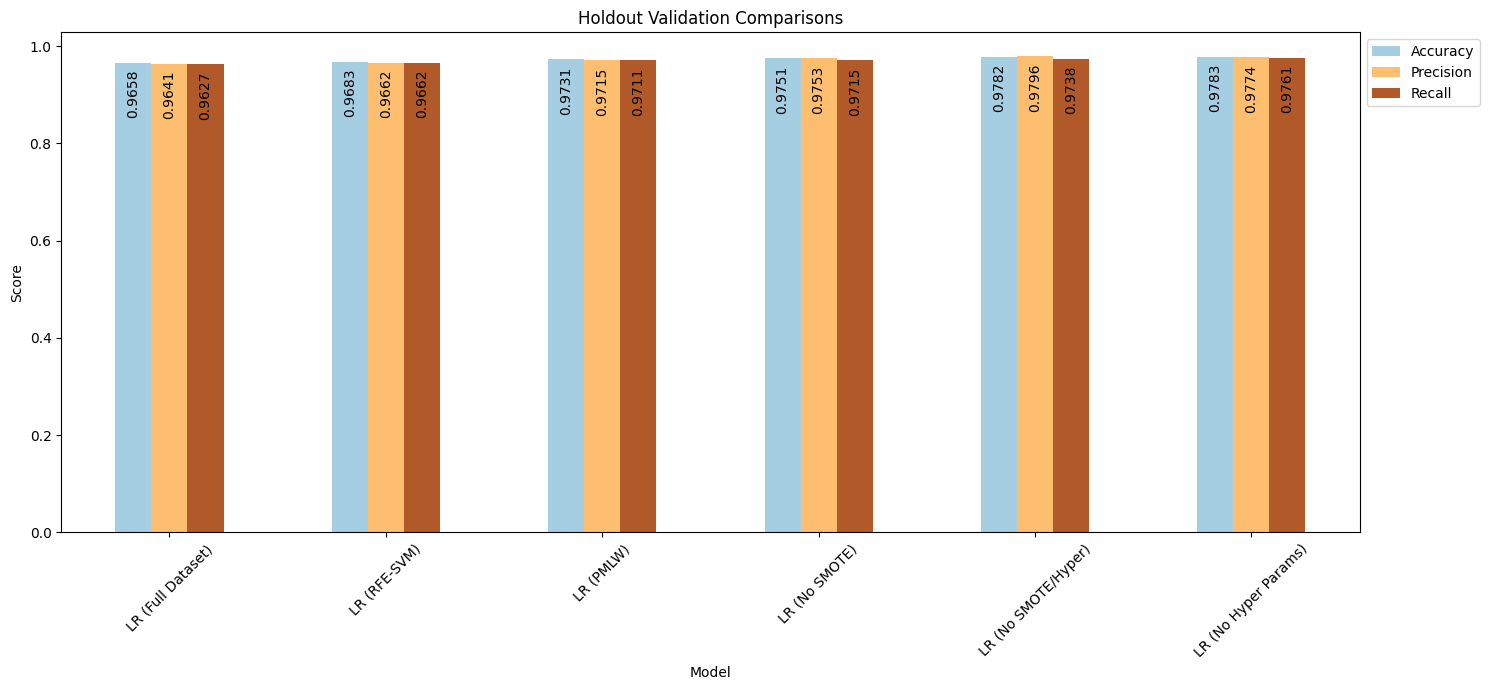

In [ ]:
show_results_chart(formatted_holdout_frame, "Holdout Validation Comparisons")

## Comments

The LR (PMLW No Smote/Hyper)is the highest-performing model across all three metrics. With the PMLW (*) being the second best, this suggests that the implementation of hyperparameter optimization was either not conducted correctly or just not advantageous for logistic regression. There is also a degradation in performance when using SMOTE() and as such it is recommended to be dropped from the final PMLW.

The LR (PMLW No Smote/Hyper)is the highest-performing model across precision and accuracy. With the PMLW No Hyper being the best scoring in terms of recall. This suggests that the implementation of hyperparameter optimization was either not conducted correctly or just not advantageous for logistic
regression. There is also a degradation in performance when using SMOTE() and as such it is recommended to be dropped from the final PMLW.

# Conclusion

In conclusion when looking at the application of the PMLW to a real-life situation one must account for the representability of the dataset to the problem. Breast cancer disproportionately affects women as
highlighted by Anderson et al., 2010, “Of all breast cancers, men with breast cancer make up less than 1%” as well as those of older age. With no indication of a patient’s gender or age within the dataset, it is impossible to gauge the representability. While the PMLW is robust and achieves great scores in all three metrics it is important to reflect on the changes the original dataset has gone through to achieve this. At multiple stages, data has been manipulated using KNN Imputation, Z-Score normalization, and the creation of synthetic records using SMOTE oversampling. The original dataset is lost in a mixture of manipulated variables, which while yielding impressive results the records do not portray the true characteristic of a breast mass tumour especially those created via SMOTE(). As the results indicate the oversampling (SMOTE()) of the dataset and Hyper Parameter Optimization (gridSearchCV()) degraded the performance of the machine learning model. Therefore, it should be noted that PMLW does not demonstrate usability in a real-world domain, nor does it provide a robust machine learning workflow but should be used as a platform for further research into areas of class imbalance and hyper optimization.